<a href="https://colab.research.google.com/github/gencturkmert/pointnet_implementation/blob/main/PointNet_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PointNet Implementation**

**Setup, Imports**

In [2]:
!pip install trimesh
!pip install numpy scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 690.2/690.2 kB 4.8 MB/s eta 0:00:00


In [3]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import data as tf_data
import keras
from keras import layers
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Reshape
from keras.optimizers import Adam


keras.utils.set_random_seed(seed=42)

**Dataset** - *ModelNet10*

In [4]:
DATA_DIR = keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473402300/473402300 [==============================] - 12s 0us/step


In [5]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

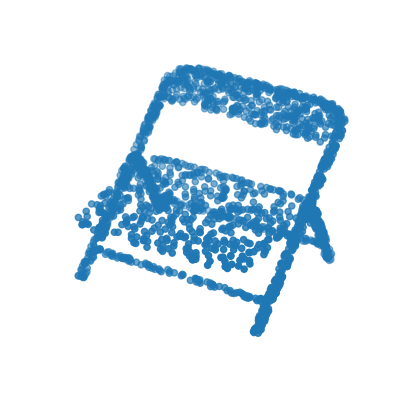

In [6]:
NUM_POINTS = 2048
points = mesh.sample(NUM_POINTS)

def show_item(points):
  fig = plt.figure(figsize=(5, 5))
  ax = fig.add_subplot(111, projection="3d")
  ax.scatter(points[:, 0], points[:, 1], points[:, 2])
  ax.set_axis_off()
  plt.show()

show_item(points)

Parse Dataset

In [7]:
train_points = []
train_labels = []
test_points = []
test_labels = []
class_map = {}
folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

for i, folder in enumerate(folders):
    print("processing class: {}".format(os.path.basename(folder)))
    class_map[i] = folder.split("/")[-1]
    train_files = glob.glob(os.path.join(folder, "train/*"))
    test_files = glob.glob(os.path.join(folder, "test/*"))

    for f in train_files:
        train_points.append(trimesh.load(f).sample(NUM_POINTS))
        train_labels.append(i)

    for f in test_files:
        test_points.append(trimesh.load(f).sample(NUM_POINTS))
        test_labels.append(i)

processing class: sofa
processing class: night_stand
processing class: dresser
processing class: table
processing class: toilet
processing class: monitor
processing class: desk
processing class: bathtub
processing class: chair
processing class: bed


Dataset size:  3991
--------------------------------
Item Size:  2048
Item Shape:  (2048, 3)
Item Label:  8
Item Label Name:  chair


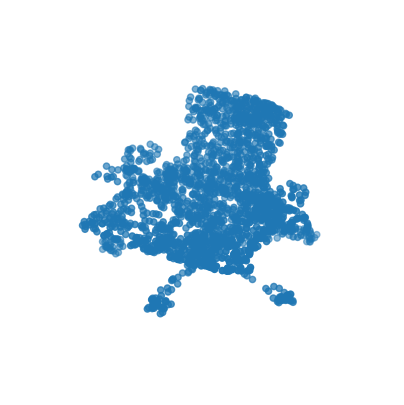

In [8]:
def show_item_with_index(index,train_points) :
  print("Dataset size: ",len(train_points))
  print("--------------------------------")
  print("Item Size: ",len(train_points[index]))
  print("Item Shape: ",train_points[index].shape)
  print("Item Label: ",train_labels[index])
  print("Item Label Name: ", class_map[train_labels[index]])
  show_item(train_points[index])

show_item_with_index(np.random.randint(0,len(train_points)),train_points)


**Augment the Dataset**

In [9]:
def augment(points,label):
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype="float64")
    points = tf.random.shuffle(points)
    return points,label

from scipy.spatial.transform import Rotation

def rotate_point(points,label):
    random_axis = np.random.rand(3)
    random_angle = np.random.uniform(0, 2*np.pi)
    rotation_matrix = Rotation.from_rotvec(random_angle * random_axis)
    points =  rotation_matrix.apply(points)

    return points,label

def rotate_cloud(items):
    random_axis = np.random.rand(3)
    random_angle = np.random.uniform(0, 2*np.pi)
    rotation_matrix = Rotation.from_rotvec(random_angle * random_axis)

    rotated_items = []
    for item in items:
        rotated_item = rotation_matrix.apply(item)
        rotated_items.append(rotated_item)

    return rotated_items


Rotate points

Dataset size:  3991
--------------------------------
Item Size:  2048
Item Shape:  (2048, 3)
Item Label:  5
Item Label Name:  monitor


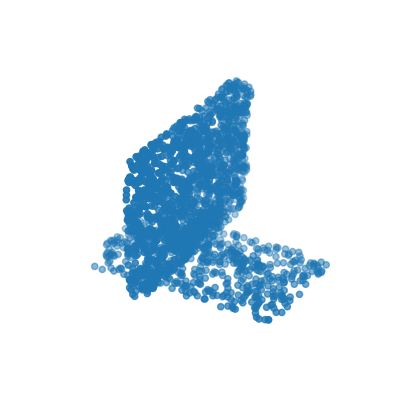

Dataset size:  3991
--------------------------------
Item Size:  2048
Item Shape:  (2048, 3)
Item Label:  0
Item Label Name:  sofa


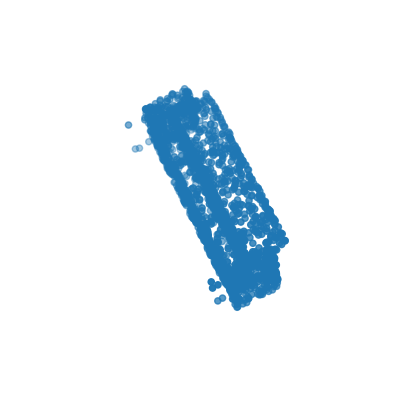

In [10]:
rotated_points = rotate_cloud(train_points)

index = np.random.randint(0,len(train_points))
show_item_with_index(index,train_points)
show_item_with_index(0,rotated_points)

In [11]:
aug_train_points = np.vstack((train_points,rotated_points))
print("Augmented points: ",aug_train_points.shape)
aug_train_labels = np.hstack((train_labels,train_labels))
print("Labels: ",aug_train_labels.shape)

Augmented points:  (7982, 2048, 3)
Labels:  (7982,)


Normalize on unit sphere / **TODO**

Dataset size:  7982
--------------------------------
Item Size:  2048
Item Shape:  (2048, 3)
Item Label:  5
Item Label Name:  monitor


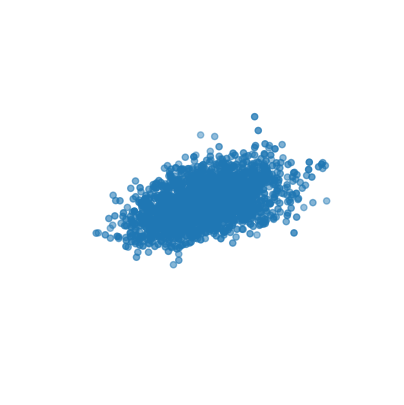

In [12]:
def normalize_pc(points):
	centroid = np.mean(points, axis=0)
	points -= centroid
	furthest_distance = np.max(np.sqrt(np.sum(abs(points)**2,axis=-1)))
	points /= furthest_distance

	return points

show_item_with_index(index,normalize_pc(aug_train_points))

Create dataset, split train, val, test

In [13]:
train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((aug_train_points, aug_train_labels))
print(dataset.element_spec)
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

(TensorSpec(shape=(2048, 3), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [14]:
NUM_CLASSES = 10
BATCH_SIZE = 32

dataset = dataset.shuffle(len(aug_train_points)).map(augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

Model Building

In [15]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

def tnet(input_shape, num_features):
    x = conv_bn(input_shape, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    return layers.Dot(axes=(2, 1))([input_shape, feat_T])


In [16]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2048, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 2048, 32)             128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 2048, 32)             128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 2048, 32)             0         ['batch_normalization[0

In [17]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
200/200 [==============================] - 49s 159ms/step - loss: 2.2706 - sparse_categorical_accuracy: 0.2166 - val_loss: 2.2399 - val_sparse_categorical_accuracy: 0.2311
Epoch 2/20
200/200 [==============================] - 31s 152ms/step - loss: 2.2211 - sparse_categorical_accuracy: 0.2227 - val_loss: 2.2022 - val_sparse_categorical_accuracy: 0.2298
Epoch 3/20
200/200 [==============================] - 31s 153ms/step - loss: 2.1905 - sparse_categorical_accuracy: 0.2190 - val_loss: 2.1771 - val_sparse_categorical_accuracy: 0.2167
Epoch 4/20
200/200 [==============================] - 33s 166ms/step - loss: 2.1688 - sparse_categorical_accuracy: 0.2274 - val_loss: 2.1661 - val_sparse_categorical_accuracy: 0.2123
Epoch 5/20
200/200 [==============================] - 31s 153ms/step - loss: 2.1524 - sparse_categorical_accuracy: 0.2257 - val_loss: 2.1499 - val_sparse_categorical_accuracy: 0.2148
Epoch 6/20
200/200 [==============================] - 31s 154ms/step - loss: 2.1499 -

In [19]:
history = model.predict(test_dataset)

29/29 [==============================] - 1s 29ms/step


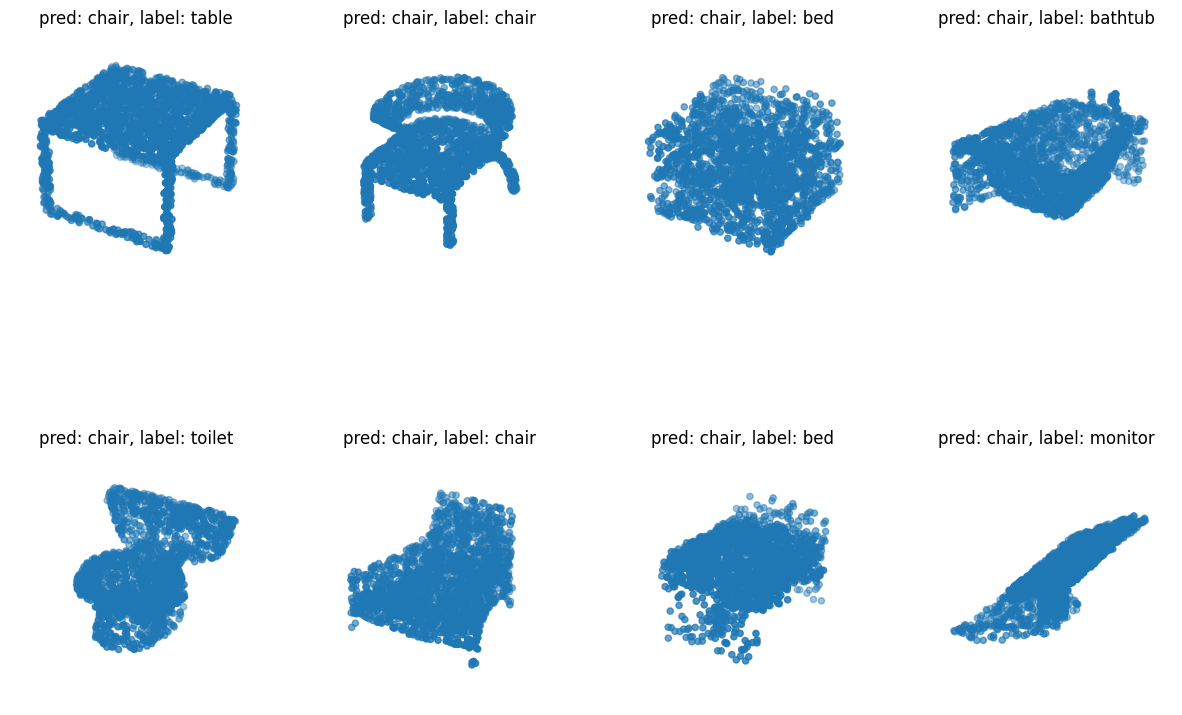

In [22]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = np.argmax(history, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            class_map[preds[i]], class_map[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()